In [2647]:
from area import area
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # converts an address into latitude and longitude values
from math import sin, cos, sqrt, atan2, radians
from scipy.ndimage.filters import gaussian_filter1d
from shapely.geometry import shape
from sklearn.cluster import KMeans 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import folium
import geocoder
import itertools
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import requests
import unittest
import re
import seaborn as sns
%matplotlib inline

# Scrape information about each Sydney suburb from Wikipedia

Here I use [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape the suburbs from Sydney as listed on [wikipedia](https://en.wikipedia.org/wiki/List_of_Sydney_suburbs). For each suburb, I identify the wikipage url for the indexed suburb, request access to the webpage, and then collect the following from their information box:
* **Postcode**: Postcode
* **Density**: Population density
* **Area**: Area size of suburb
* **LGA**: Local government assocation (council)
* **Location**: Distance from the city

In [2]:
with open("view-source_https___en.wikipedia.org_wiki_List_of_Sydney_suburbs.html") as html_file:
    soup = BeautifulSoup(html_file,
                         "lxml"
                        )

syd_suburbs_section = soup.find('div',
                                attrs={'class':'mw-parser-output'}
                               )

syd_suburbs_section = syd_suburbs_section.findAll('a',
                                                  href=True
                                                 )

In [3]:
# Scrape url for each suburb
def get_wiki_urls(html_suburbs_section,
                  wiki_link_extension,
                  wiki_state_name,
                  state,
                 ):
    
    url_list = {}
    for i in range(len(html_suburbs_section)):
        #print(i)
        url = html_suburbs_section[i]['href']
        if wiki_link_extension in url:
            
            check_list = []
            for x in ['/File:',
                      '/List_of_']:
                
                if x in url:
                    check_list.append(1)
            
            if sum(check_list) >= 1:
                continue
            else:
                suburb = html_suburbs_section[i]['title'].replace(wiki_state_name,'')

                if suburb in url_list:
                    continue           

                else:
                    url_list[suburb] = 'https://en.wikipedia.org{}'.format(url)
        
        # Sydney cbd
        elif '{}_CBD'.format(state) in url:
            suburb = html_suburbs_section[i]['title'] 
            url_list[suburb] = 'https://en.wikipedia.org{}'.format(url)

        # Brisbane cbd
        elif '{}_central_business_district'.format(state) in url:
            suburb = html_suburbs_section[i]['title']
            url_list[suburb] = 'https://en.wikipedia.org{}'.format(url)
        else:
            continue
    
    return url_list

In [4]:
wiki_state_name = ', New South Wales'
wiki_link_extension = ',_New_South_Wales'
state = 'Sydney'
syd_wiki_urls = get_wiki_urls(syd_suburbs_section,
                              wiki_link_extension,
                              wiki_state_name,
                              state,
                             )
#syd_wiki_urls

In [2223]:
# Scrape information box for each suburb from their wikipage.
# If an information box doesn't exist a try/catch error for the AttributeError will pass it.

def get_suburb_wiki_infobox(wiki_urls):
    
    suburbs_infobox = {}
    for key,value in syd_wiki_urls.items():

        try:
            page = requests.get(value)
            soup_page = BeautifulSoup(page.text, 'html.parser')

            try:
                print('Check redirection: {}'.format(key))
                soup_redirect = soup_page.find('span', class_='mw-redirectedfrom').a['href']
                soup_redirect_title = soup_redirect.replace(' ','_')
                soup_redirect_url = 'https://en.wikipedia.org{}'.format(soup_redirect)

                page = requests.get(soup_redirect_url)
                soup_redirect_page = BeautifulSoup(page.text, 'html.parser')
                soup_redirect_page_title = soup_redirect_page.find('ul', class_='redirectText').a['title']
                
                if key not in soup_redirect_page_title:
                    print('Incorrect Redirection exists: {}\n'.format(key))
                    # Link redirects to wrong page
                    # Go to next suburb.
                    # Suburb not added to list
                    continue
                elif key in soup_redirect_page_title:
                    print('Correct Redirection exists: {}'.format(key))
                    pass
                
            except:
                # If statement may fail because redirection doesn't exist in wikipage.
                # Therefore pass onto with next block of code.
                print('Redirection does not exists: {}'.format(key))               
                pass
            # Scrape information box from suburb wiki page
            print('Scraping infobox: {}\n'.format(key))  
            infobox = soup_page.find('table', class_='infobox vcard')
            suburbs_infobox[key] = infobox.find_all('tr', class_='')

        except AttributeError:
            # print("No infobox: {}".format(key))
            suburbs_infobox[key] = None
            continue
    
    return suburbs_infobox

In [2224]:
syd_suburb_infobox = get_suburb_wiki_infobox(syd_wiki_urls)

Check redirection: Bankstown
Correct Redirection exists: Bankstown
Scraping infobox: Bankstown

Check redirection: Bondi Beach
Correct Redirection exists: Bondi Beach
Scraping infobox: Bondi Beach

Check redirection: Sydney central business district
Redirection does not exists: Sydney central business district
Scraping infobox: Sydney central business district

Check redirection: Chatswood
Redirection does not exists: Chatswood
Scraping infobox: Chatswood

Check redirection: Cronulla
Redirection does not exists: Cronulla
Scraping infobox: Cronulla

Check redirection: Liverpool
Redirection does not exists: Liverpool
Scraping infobox: Liverpool

Check redirection: Manly
Redirection does not exists: Manly
Scraping infobox: Manly

Check redirection: Milsons Point
Redirection does not exists: Milsons Point
Scraping infobox: Milsons Point

Check redirection: Mosman
Redirection does not exists: Mosman
Scraping infobox: Mosman

Check redirection: Newtown
Redirection does not exists: Newtown
Sc

Check redirection: Blakehurst
Redirection does not exists: Blakehurst
Scraping infobox: Blakehurst

Check redirection: Bligh Park
Redirection does not exists: Bligh Park
Scraping infobox: Bligh Park

Check redirection: Bondi
Redirection does not exists: Bondi
Scraping infobox: Bondi

Check redirection: Bondi Junction
Redirection does not exists: Bondi Junction
Scraping infobox: Bondi Junction

Check redirection: Bonnet Bay
Redirection does not exists: Bonnet Bay
Scraping infobox: Bonnet Bay

Check redirection: Bonnyrigg
Redirection does not exists: Bonnyrigg
Scraping infobox: Bonnyrigg

Check redirection: Bonnyrigg Heights
Correct Redirection exists: Bonnyrigg Heights
Scraping infobox: Bonnyrigg Heights

Check redirection: Bossley Park
Correct Redirection exists: Bossley Park
Scraping infobox: Bossley Park

Check redirection: Botany
Redirection does not exists: Botany
Scraping infobox: Botany

Check redirection: Bow Bowing
Redirection does not exists: Bow Bowing
Scraping infobox: Bow B

Correct Redirection exists: Collaroy Plateau
Scraping infobox: Collaroy Plateau

Check redirection: Colyton
Redirection does not exists: Colyton
Scraping infobox: Colyton

Check redirection: Como
Redirection does not exists: Como
Scraping infobox: Como

Check redirection: Concord
Redirection does not exists: Concord
Scraping infobox: Concord

Check redirection: Concord West
Redirection does not exists: Concord West
Scraping infobox: Concord West

Check redirection: Condell Park
Correct Redirection exists: Condell Park
Scraping infobox: Condell Park

Check redirection: Connells Point
Redirection does not exists: Connells Point
Scraping infobox: Connells Point

Check redirection: Constitution Hill
Redirection does not exists: Constitution Hill
Scraping infobox: Constitution Hill

Check redirection: Coogee
Redirection does not exists: Coogee
Scraping infobox: Coogee

Check redirection: Cornwallis
Redirection does not exists: Cornwallis
Scraping infobox: Cornwallis

Check redirection: Cott

Check redirection: Eveleigh
Redirection does not exists: Eveleigh
Scraping infobox: Eveleigh

Check redirection: Fairfield
Redirection does not exists: Fairfield
Scraping infobox: Fairfield

Check redirection: Fairfield East
Correct Redirection exists: Fairfield East
Scraping infobox: Fairfield East

Check redirection: Fairfield Heights
Redirection does not exists: Fairfield Heights
Scraping infobox: Fairfield Heights

Check redirection: Fairfield West
Redirection does not exists: Fairfield West
Scraping infobox: Fairfield West

Check redirection: Fairlight
Redirection does not exists: Fairlight
Scraping infobox: Fairlight

Check redirection: Fiddletown
Redirection does not exists: Fiddletown
Scraping infobox: Fiddletown

Check redirection: Five Dock
Redirection does not exists: Five Dock
Scraping infobox: Five Dock

Check redirection: Flemington
Redirection does not exists: Flemington
Scraping infobox: Flemington

Check redirection: Forest Glen
Redirection does not exists: Forest Glen

Check redirection: Jamisontown
Correct Redirection exists: Jamisontown
Scraping infobox: Jamisontown

Check redirection: Jannali
Correct Redirection exists: Jannali
Scraping infobox: Jannali

Check redirection: Jordan Springs
Redirection does not exists: Jordan Springs
Scraping infobox: Jordan Springs

Check redirection: Kangaroo Point
Redirection does not exists: Kangaroo Point
Scraping infobox: Kangaroo Point

Check redirection: Kareela
Correct Redirection exists: Kareela
Scraping infobox: Kareela

Check redirection: Kearns
Redirection does not exists: Kearns
Scraping infobox: Kearns

Check redirection: Kellyville
Redirection does not exists: Kellyville
Scraping infobox: Kellyville

Check redirection: Kellyville Ridge
Redirection does not exists: Kellyville Ridge
Scraping infobox: Kellyville Ridge

Check redirection: Kemps Creek
Redirection does not exists: Kemps Creek
Scraping infobox: Kemps Creek

Check redirection: Kensington
Redirection does not exists: Kensington
Scraping infobo

Check redirection: Matraville
Redirection does not exists: Matraville
Scraping infobox: Matraville

Check redirection: Mays Hill
Redirection does not exists: Mays Hill
Scraping infobox: Mays Hill

Check redirection: McCarrs Creek
Redirection does not exists: McCarrs Creek
Scraping infobox: McCarrs Creek

Check redirection: McGraths Hill
Redirection does not exists: McGraths Hill
Scraping infobox: McGraths Hill

Check redirection: McMahons Point
Correct Redirection exists: McMahons Point
Scraping infobox: McMahons Point

Check redirection: Meadowbank
Redirection does not exists: Meadowbank
Scraping infobox: Meadowbank

Check redirection: Melrose Park
Redirection does not exists: Melrose Park
Scraping infobox: Melrose Park

Check redirection: Menai
Redirection does not exists: Menai
Scraping infobox: Menai

Check redirection: Menangle Park
Redirection does not exists: Menangle Park
Scraping infobox: Menangle Park

Check redirection: Merrylands
Redirection does not exists: Merrylands
Scra

Check redirection: Oyster Bay
Redirection does not exists: Oyster Bay
Scraping infobox: Oyster Bay

Check redirection: Paddington
Redirection does not exists: Paddington
Scraping infobox: Paddington

Check redirection: Padstow
Redirection does not exists: Padstow
Scraping infobox: Padstow

Check redirection: Padstow Heights
Correct Redirection exists: Padstow Heights
Scraping infobox: Padstow Heights

Check redirection: Pagewood
Redirection does not exists: Pagewood
Scraping infobox: Pagewood

Check redirection: Palm Beach
Redirection does not exists: Palm Beach
Scraping infobox: Palm Beach

Check redirection: Panania
Correct Redirection exists: Panania
Scraping infobox: Panania

Check redirection: Parklea
Correct Redirection exists: Parklea
Scraping infobox: Parklea

Check redirection: Peakhurst
Redirection does not exists: Peakhurst
Scraping infobox: Peakhurst

Check redirection: Peakhurst Heights
Redirection does not exists: Peakhurst Heights
Scraping infobox: Peakhurst Heights

Che

Check redirection: Sefton
Redirection does not exists: Sefton
Scraping infobox: Sefton

Check redirection: Seven Hills
Redirection does not exists: Seven Hills
Scraping infobox: Seven Hills

Check redirection: Shalvey
Redirection does not exists: Shalvey
Scraping infobox: Shalvey

Check redirection: Shanes Park
Redirection does not exists: Shanes Park
Scraping infobox: Shanes Park

Check redirection: Silverwater
Redirection does not exists: Silverwater
Scraping infobox: Silverwater

Check redirection: Singletons Mill
Redirection does not exists: Singletons Mill
Scraping infobox: Singletons Mill

Check redirection: Smeaton Grange
Redirection does not exists: Smeaton Grange
Scraping infobox: Smeaton Grange

Check redirection: Smithfield
Redirection does not exists: Smithfield
Scraping infobox: Smithfield

Check redirection: South Coogee
Redirection does not exists: South Coogee
Scraping infobox: South Coogee

Check redirection: South Granville
Redirection does not exists: South Granville

Check redirection: West Pennant Hills
Redirection does not exists: West Pennant Hills
Scraping infobox: West Pennant Hills

Check redirection: West Pymble
Redirection does not exists: West Pymble
Scraping infobox: West Pymble

Check redirection: West Ryde
Redirection does not exists: West Ryde
Scraping infobox: West Ryde

Check redirection: Westleigh
Redirection does not exists: Westleigh
Scraping infobox: Westleigh

Check redirection: Westmead
Redirection does not exists: Westmead
Scraping infobox: Westmead

Check redirection: Wetherill Park
Redirection does not exists: Wetherill Park
Scraping infobox: Wetherill Park

Check redirection: Whalan
Redirection does not exists: Whalan
Scraping infobox: Whalan

Check redirection: Whale Beach
Redirection does not exists: Whale Beach
Scraping infobox: Whale Beach

Check redirection: Wheeler Heights
Redirection does not exists: Wheeler Heights
Scraping infobox: Wheeler Heights

Check redirection: Wilberforce
Redirection does not exists: Wilberf

Function that scrapes data from wikipedia htmls of different suburbs in Australia. Here I apply it Sydney and Brisbane.

Location (distance from the cbd), area (size of the suburb), and population density are not found for many suburbs wikipages. Therefore, the location and area information will not be scraped and instead will be determined with geopy. And the density information will be calculated from the scraped population data with the geopy area data.

In [1923]:
def get_suburb_info(suburb_infobox):
    CHECK_STRINGS = (
                     'Postcode',
                     'Population',
                    )

    suburbs = {}

    for key,value in suburb_infobox.items():

        try:
            infobox_val = value
            items = {}

            for val in infobox_val:        

                check_list = []
                for s in CHECK_STRINGS:
                    if s in val.text:
                        check_list.append(s)
                        break
                
                if len(check_list) >= 1:
                    keyword = check_list[0]
                    infobox_split = val.text.split(' ')

                    if len(infobox_split) > 1:
                        infobox_item = [s for s in infobox_split if str(keyword) in s]
                        # Remove substrings from string
                        info = infobox_item[0]
                        info = info.replace("Population","")\
                                   .replace(',','')\
                                   .replace("Area","")\
                                   .replace('\xa0km2',' ')\
                                   .replace(',','')

                        info = info.split('\xa0(')
                        info = info[0]

                        # Convert Area, Density, and Location columns from string to numeric
                        try:
                            info = float(info)
                            items[keyword] = info
                        except:
                            info = None 
                            items[keyword] = info

                    elif len(infobox_split) == 1:
                        info = infobox_split[0]
                        info = info.replace("Postcode(s)","")\
                                   .replace("Population","")\
                                   .replace(',','')\
                                   .replace('\xa0(2016)','')
                        info = info.split('[')
                        info = info[0]
                        if keyword == 'Population':
                            info = int(info)
                        items[keyword] = info

                elif 'LGA' in val.text:
                    info = val.text.replace("LGA(s)","")\
                                   .replace(";",")")
                    info = info.split('[')
                    info = info[0]
                    items['LGA'] = info

                else:
                    continue

            suburbs[key] = items

        except TypeError:         
            # Print suburbs that don't have an infobox
            print(key)
            # Suburbs that don't have an infobox are not added to the dictionary.
            continue
    
    return suburbs

In [2225]:
sydney_suburbs = get_suburb_info(syd_suburb_infobox)

East Gordon
North St Ives
Scotland Island
Singletons Mill
West Killara
West Lindfield


In [2258]:
# Convert Sydney suburbs nested dictionary to a dataframe
sydney_suburbs_df = pd.DataFrame(sydney_suburbs).T
sydney_suburbs_df['Suburb'] = sydney_suburbs_df.index
sydney_suburbs_df.index = range(sydney_suburbs_df.shape[0])

sydney_suburbs_df.head(5)

,LGA,Population,Postcode,Suburb
0,Canterbury-Bankstown Council,32113,2200,Bankstown
1,Waverley Council,11656,2026,Bondi Beach
2,City of Sydney,17252,2000,Sydney central business district
3,City of Willoughby,24913,2067,Chatswood
4,Sutherland Shire,18070,2230,Cronulla


### Suburbs that didn't have a postcode on their wikipage.

In [2260]:
missing_postcodes = sydney_suburbs_df[sydney_suburbs_df['Postcode'].isnull()]
missing_postcodes.reset_index(inplace=True,
                              drop=True
                             )
missing_postcodes

,LGA,Population,Postcode,Suburb
0,NaN,NaN,NaN,Bankstown Airport
1,Hornsby Shire,12000,None,Berowra
2,Hornsby Shire,213,NaN,Berowra Creek
3,Hornsby Shire,5264,None,Berowra Heights
4,Northern Beaches Council,240,NaN,Bilgola Beach
5,City of Hawkesbury,122,NaN,Clarendon
6,City of Parramatta,5412,NaN,Dundas Valley
7,City of Blacktown,3453,NaN,Kings Park
8,NaN,NaN,NaN,Ku-ring-gai Chase
9,Hornsby Shire,112,NaN,Milsons Passage


Two things that stick out:

* Macarther is a south-west NSW region made up of three local LGA's and therefore is considered as as a suburb.
* Bankstown Airport is an airport not a suburb.
* Royal National Park is a coastline park.
* Ku-ring-gai Chase is a park in the northern region of sydney.

Therefore, Macarthur and Bankstown Airport will be removed from the dataframes.

In [2261]:
# Drop Macarthur row.
to_drop = ['Bankstown Airport',
           'Macarthur',
           'Royal National Park',
           'Ku-ring-gai Chase'
          ]

sydney_suburbs_df = sydney_suburbs_df[~sydney_suburbs_df['Suburb'].isin(to_drop)]
sydney_suburbs_df.reset_index(inplace=True, drop=True)
missing_postcodes = missing_postcodes[~missing_postcodes['Suburb'].isin(to_drop)]
missing_postcodes.reset_index(inplace=True, drop=True)

Function to get postcodes with geopy

In [2263]:
def get_missing_postcodes_geopy(missing_pc_df,
                                city_str,
                                state_str
                               ):
    geolocator = Nominatim(user_agent="specify_your_app_name_here",
                           timeout=3
                          )
    
    geo_pc = {}
    
    for index,row in missing_pc_df.iterrows():
        suburb = row['Suburb']
        location = geolocator.geocode("{}, {}, {}, Australia".format(suburb,
                                                                     city_str,
                                                                     state_str
                                                                    ),
                                      geometry='geojson')
        
        display_name = location.raw['display_name']
        pc = re.findall(r'\b\d+\b', display_name)
        
        try:
            geo_pc[suburb] = pc[0]
        except(IndexError):
            # Suburbs that don't have postcodes. Need to find and fill in manually.
            geo_pc[suburb] = 'nan'

    return geo_pc

In [2264]:
geo_pc_dict = get_missing_postcodes_geopy(missing_postcodes,
                                          'Sydney',
                                          'New South Wales'
                                         )

In [2265]:
geo_pc_dict

{'Berowra': '2081',
 'Berowra Creek': '2080',
 'Berowra Heights': '2082',
 'Bilgola Beach': '2107',
 'Clarendon': '2756',
 'Dundas Valley': '2117',
 'Kings Park': '2148',
 'Milsons Passage': '2083',
 'Seven Hills': '2147',
 'Shanes Park': '2747',
 'Vaucluse': '2030'}

In [2266]:
geo_pc_df = pd.DataFrame([geo_pc_dict]).T
geo_pc_df.columns = ['Postcode']
geo_pc_df.insert(0, 'Suburb', geo_pc_df.index)
geo_pc_df.index = range(geo_pc_df.shape[0])

In [2284]:
missing_postcodes = missing_postcodes.assign(Postcode=missing_postcodes.Suburb.map(geo_pc_list).fillna(missing_postcodes.Suburb))

Merge this dataframe with the main sydney suburbs dataframe

In [2285]:
sydney_suburbs_df = pd.concat([
                               sydney_suburbs_df,
                               missing_postcodes,
                              ],
                              axis=0
                             )

sydney_suburbs_df.reset_index(inplace=True,
                              drop=True,
                             )

In [2286]:
sydney_suburbs_df.drop_duplicates(subset='Suburb',
                                  keep='last',
                                  inplace=True,
                                 )
sydney_suburbs_df.reset_index(inplace=True,
                              drop=True)

# Get Geographical Coordinates

Function to get the list of geographical coordiantes for each suburb in the city

In [2438]:
def get_latlon_polygon(df_list,
                       city,
                       state,
                      ):
    
    geolocator = Nominatim(user_agent="specify_your_app_name_here",
                           timeout=3,
                          )

    lat = {}
    lon = {}
    polygon = {}
    
    for index,row in df_list.iterrows():
        suburb = row.Suburb
        # 'Central business district' not detected by geopy. Therefore change it to 'cbd'.
        if 'central business district' in suburb:
            suburb_split = suburb.split(' ')
            suburb = '{} cbd'.format(suburb_split[0])
        postcode = row.Postcode
        
        # For some reason certain suburbs can only be identified with certain suburb/postcode/city/state combinations.
        # >>> Need to clean up IF statement sequences.
        try:
            print('TRY          {}, {}'.format(suburb, postcode))
            if any(x in suburb for x in ['Beach',
                                         'Bay']):
                suburb_replace = '{} area'.format(suburb)
                location = geolocator.geocode("{}, {}, {}, Australia".format(suburb_replace,
                                                                             city,
                                                                             state,
                                                                            ),
                                              geometry='geojson')
            else:
                location = geolocator.geocode("{}, {}, {}, Australia".format(suburb,
                                                                             city,
                                                                             state),
                                              geometry='geojson')
                
            if location.raw['geojson']['type'] in ['Point',
                                                   'LineString']:
                print('TRY IF       {}, {}'.format(suburb, postcode))
                location = geolocator.geocode("{}, {}, Australia".format(suburb,
                                                                         state
                                                                        ),
                                              geometry='geojson')
                
                if location.raw['geojson']['type'] in ['Point',
                                                       'LineString']:
                    print('TRY IF IF    {}, {}'.format(suburb, postcode))
                    location = geolocator.geocode("{}, {}, {}, Australia".format(suburb,
                                                                                 postcode,
                                                                                 state
                                                                                ),
                                                  geometry='geojson')

                    if location.raw['geojson']['type'] in ['Point',
                                                           'LineString']:
                        suburb_replace = suburb.replace('Creek', '')
                        print('TRY IF IF IF {}, {}'.format(suburb, postcode))
                        location = geolocator.geocode("{} area, {}, {}".format(suburb_replace,
                                                                               city,
                                                                               state
                                                                              ),
                                                      geometry='geojson')
                    
        # For suburbs that have been identified however don't have
        # latitude/longitude coordinates are  moved to the except phase.        
        except:
            print('EXCEPT       {}, {}'.format(suburb, postcode))
            location = geolocator.geocode("{}, {}, {}, Australia".format(suburb,
                                                                         postcode,
                                                                         state
                                                                        ),
                                          geometry='geojson')
            
        lat[suburb] = location.latitude
        lon[suburb] = location.longitude
        polygon[suburb] = location.raw['geojson']
    
    # Change cbd back to central business district
    lat['{} central business district'.format(suburb_split[0])] = lat.pop('Sydney cbd')
    lon['{} central business district'.format(suburb_split[0])] = lon.pop('Sydney cbd')
    polygon['{} central business district'.format(suburb_split[0])] = polygon.pop('Sydney cbd')
    
    return lat, lon, polygon

Get geographical coordinates for Sydney suburbs

In [2439]:
lat, lon, polygon = get_latlon_polygon(sydney_suburbs_df, 'Sydney', 'New South Wales')

TRY          Bankstown, 2200
TRY          Bondi Beach, 2026
TRY          Sydney cbd, 2000
TRY          Chatswood, 2067
TRY          Cronulla, 2230
TRY          Liverpool, 2170
TRY          Manly, 2095
TRY          Milsons Point, 2061
TRY          Mosman, 2088
TRY          Newtown, 2042
TRY          Parramatta, 2150
TRY          The Rocks, 2000
TRY          Abbotsbury, 2176
TRY          Abbotsford, 2046
TRY          Acacia Gardens, 2763
TRY          Agnes Banks, 2753
TRY          Airds, 2560
TRY          Alexandria, 2015
TRY          Alfords Point, 2234
TRY          Allambie Heights, 2100
TRY          Allawah, 2218
TRY          Ambarvale, 2560
TRY          Annandale, 2038
TRY          Annangrove, 2156
TRY          Arcadia, 2159
TRY          Arncliffe, 2205
TRY          Arndell Park, 2148
TRY          Artarmon, 2064
TRY          Ashbury, 2193
TRY          Ashcroft, 2168
TRY          Ashfield, 2131
TRY          Asquith, 2077
TRY          Auburn, 2144
TRY          Austral, 2179
TRY        

TRY          Gordon, 2072
TRY          Granville, 2142
TRY          Grasmere, 2570
TRY          Grays Point, 2232
TRY          Great Mackerel Beach, 2108
TRY          Green Valley, 2168
TRY          Greenacre, 2190
TRY          Greendale, 2745
TRY          Greenfield Park, 2176
TRY          Greenhills Beach, 2230
TRY          Greenwich, 2065
TRY          Gregory Hills, 2557
TRY          Greystanes, 2145
TRY          Grose Vale, 2753
TRY          Grose Wold, 2753
TRY          Guildford, 2161
TRY          Guildford West, 2161
TRY          Gymea, 2227
TRY          Gymea Bay, 2227
TRY          Haberfield, 2045
TRY          Hammondville, 2170
TRY          Harrington Park, 2567
TRY          Harris Park, 2150
TRY          Hassall Grove, 2761
TRY          Haymarket, 2000
TRY          Heathcote, 2233
TRY          Hebersham, 2770
TRY          Heckenberg, 2168
TRY          Henley, 2111
TRY          Hillsdale, 2036
TRY          Hinchinbrook, 2168
TRY          Hobartville, 2753
TRY          Holroyd

TRY          Ropes Crossing, 2760
TRY          Rose Bay, 2029
TRY          Rosebery, 2018
TRY          Rosehill, 2142
TRY          Roselands, 2196
TRY          Rosemeadow, 2560
TRY          Roseville, 2069
TRY          Roseville Chase, 2069
TRY          Rossmore, 2557
TRY          Rouse Hill, 2155
TRY          Rozelle, 2039
TRY          Ruse, 2560
TRY          Rushcutters Bay, 2011
TRY          Russell Lea, 2046
TRY          Rydalmere, 2116
TRY          Ryde, 2112
TRY          Sackville, 2756
TRY          Sackville North, 2756
TRY          Sadleir, 2168
TRY          Sandringham, 2219
TRY          Sandy Point, 2172
TRY          Sans Souci, 2219
TRY          Scheyville, 2756
TRY          Schofields, 2762
TRY          Seaforth, 2092
TRY          Sefton, 2162
TRY          Shalvey, 2770
TRY          Silverwater, 2128
TRY          Smeaton Grange, 2567
TRY          Smithfield, 2164
TRY          South Coogee, 2034
TRY          South Granville, 2142
TRY          South Hurstville, 2221
TRY      

In [2628]:
# Combine dictionaries to single dataframe
latlon_polgon_df = pd.DataFrame([lat, lon, polygon]).T
# Rename columns
latlon_polgon_df.columns = ['lat', 'lon', 'polygon']

latlon_polgon_df.insert(0, 'Suburb', latlon_polgon_df.index)
latlon_polgon_df.index = range(latlon_polgon_df.shape[0])
latlon_polgon_df.head()

,Suburb,lat,lon,polygon
0,Abbotsbury,-33.8693,150.867,"{'type': 'Polygon', 'coordinates': [[[150.8423..."
1,Abbotsford,-33.8506,151.13,"{'type': 'Polygon', 'coordinates': [[[151.1221..."
2,Acacia Gardens,-33.7325,150.913,"{'type': 'Polygon', 'coordinates': [[[150.9062..."
3,Agnes Banks,-33.6145,150.711,"{'type': 'Polygon', 'coordinates': [[[150.6725..."
4,Airds,-34.09,150.826,"{'type': 'Polygon', 'coordinates': [[[150.8205..."


Add longitude, latitude, and polygon dataframe to main dataframe

In [2629]:
syd_suburbs_coord = sydney_suburbs_df.merge(latlon_polgon_df, left_on='Suburb', right_on='Suburb')

In [2630]:
syd_suburbs_coord.head()

,LGA,Population,Postcode,Suburb,lat,lon,polygon
0,Canterbury-Bankstown Council,32113,2200,Bankstown,-33.9172,151.034,"{'type': 'Polygon', 'coordinates': [[[151.0111..."
1,Waverley Council,11656,2026,Bondi Beach,-33.8907,151.272,"{'type': 'Polygon', 'coordinates': [[[151.2624..."
2,City of Sydney,17252,2000,Sydney central business district,-33.868,151.21,"{'type': 'Polygon', 'coordinates': [[[151.1970..."
3,City of Willoughby,24913,2067,Chatswood,-33.7945,151.182,"{'type': 'Polygon', 'coordinates': [[[151.1588..."
4,Sutherland Shire,18070,2230,Cronulla,-34.0575,151.152,"{'type': 'Polygon', 'coordinates': [[[151.1432..."


# Calculate geographical distance to Sydney CBD

Function that calculates the geographical distance between two sets of latitude and longitude coordinates and outputs hte list as a dataframe

In [2631]:
def calc_geo_dist(lat1, lon1, lat2, lon2):
    R = 6373.0

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [2632]:
def get_suburb_geo_dist(suburb_df):
    
    cbd_coord = []    
    for geo_dir in ['lat', 'lon']:
        # Change to central business district or CBD
        cbd_coord.append(suburb_df.loc[suburb_df['Suburb'].str.contains('CBD|central business district')==True][geo_dir].values[0])

    lat1 = radians(cbd_coord[0])
    lon1 = radians(cbd_coord[1])
    
    dist = {}
    for row in range(suburb_df.shape[0]):
        suburb = syd_suburbs_coord.iloc[syd_suburbs_coord.index[row]]['Suburb']
        
        lat2 = radians(suburb_df.iloc[suburb_df.index[row]]['lat'])
        lon2 = radians(suburb_df.iloc[suburb_df.index[row]]['lon'])
        
        geo_distance = calc_geo_dist(lat1, lon1, lat2, lon2)
        
        dist[suburb] = round(geo_distance,2)
    
    return dist

In [2635]:
sydney_geo_distances = get_suburb_geo_dist(syd_suburbs_coord)

In [2636]:
dist_df = pd.DataFrame(list(sydney_geo_distances.items()), columns=['Suburb', 'geo_dist'])
dist_df.head()

,Suburb,geo_dist
0,Bankstown,17.19
1,Bondi Beach,6.29
2,Sydney central business district,0.00
3,Chatswood,8.58
4,Cronulla,21.75


Add geographical distances to main suburb dataframe

In [2637]:
syd_suburbs_coord = syd_suburbs_coord.merge(dist_df, left_on='Suburb', right_on='Suburb')

# Calculate geographical area

List different types of polygons in the dataframe

In [2638]:
polygon_type = []
for index, row in syd_suburbs_coord.iterrows():
    polygon_type.append(row['polygon']['type'])
    
np.unique(polygon_type)

array(['LineString', 'MultiPolygon', 'Point', 'Polygon'], dtype='<U12')

We see that there are 4 types of polygons:
* LineString
* MultiPolygon
* Point
* Polygon

Draw an example of each polygon

In [2639]:
LineString = {}
MultiPolygon = {}
Point = {}
Polygon = {}

for index, row in syd_suburbs_coord.iterrows():
    poly_row = row['polygon']['type']
    if poly_row == 'LineString':
        LineString[row['Suburb']] = row['polygon']
        
    elif poly_row == 'MultiPolygon':
        MultiPolygon[row['Suburb']] = row['polygon']
        
    elif poly_row == 'Point':
        Point[row['Suburb']] = row['polygon']
        
    elif poly_row == 'Polygon':
        Polygon[row['Suburb']] = row['polygon']
        
        

In [2640]:
print('ListString suburbs are: {}'.format(list(LineString.keys())))
print('')
print('MultiPolygon suburbs are: {}'.format(list(MultiPolygon.keys())))
print('')
print('Point suburbs are: {}'.format(list(Point.keys())))
print('')
print('Polygon suburbs are: {}'.format(list(Polygon.keys())))

ListString suburbs are: ['Flemington']

MultiPolygon suburbs are: ['Chatswood West', 'Lovett Bay']

Point suburbs are: ['Len Waters Estate']

Polygon suburbs are: ['Bankstown', 'Bondi Beach', 'Sydney central business district', 'Chatswood', 'Cronulla', 'Liverpool', 'Manly', 'Milsons Point', 'Mosman', 'Newtown', 'Parramatta', 'The Rocks', 'Abbotsbury', 'Abbotsford', 'Acacia Gardens', 'Agnes Banks', 'Airds', 'Alexandria', 'Alfords Point', 'Allambie Heights', 'Allawah', 'Ambarvale', 'Annandale', 'Annangrove', 'Arcadia', 'Arncliffe', 'Arndell Park', 'Artarmon', 'Ashbury', 'Ashcroft', 'Ashfield', 'Asquith', 'Auburn', 'Austral', 'Avalon Beach', 'Badgerys Creek', 'Balgowlah', 'Balgowlah Heights', 'Balmain', 'Balmain East', 'Bangor', 'Banksia', 'Banksmeadow', 'Barangaroo', 'Barden Ridge', 'Bardia', 'Bardwell Park', 'Bardwell Valley', 'Bass Hill', 'Baulkham Hills', 'Bayview', 'Beacon Hill', 'Beaconsfield', 'Beaumont Hills', 'Beecroft', 'Belfield', 'Bella Vista', 'Bellevue Hill', 'Belmore', 'Bel

Suburbs to be removed from syd_suburbs_coord:
* Flemington, 2140 - a locality
* Len Waters Estate, 2171 - industrial suburb

In [2641]:
to_drop = ['Flemington', 'Len Waters Estate']
syd_suburbs_coord = syd_suburbs_coord[~syd_suburbs_coord['Suburb'].isin(to_drop)]
syd_suburbs_coord.reset_index(inplace=True, drop=True)

Draw shape of suburb

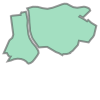

In [2649]:
# # Shape of Chatswood West
geometry = shape(syd_suburbs_coord.loc[syd_suburbs_coord['Suburb'] == 'Chatswood West']['polygon'].values[0])
geometry

Function that calculates area of polygons from a dataframe.

In [2650]:
def get_geometry_area(suburbs_df):
    geometry_area = {}

    for index, row in suburbs_df.iterrows():
        geometry_area[row['Suburb']] = (shape(row['polygon']).area) * (10**4)

    return geometry_area

In [2651]:
geometry_area = get_geometry_area(syd_suburbs_coord)

In [2652]:
geo_area_df = pd.DataFrame([geometry_area]).T
geo_area_df.columns = ['geo_area']
geo_area_df.insert(0, 'Suburb', geo_area_df.index)
geo_area_df.index = range(geo_area_df.shape[0])
geo_area_df.head()

,Suburb,geo_area
0,Abbotsbury,4.850828
1,Abbotsford,0.987710
2,Acacia Gardens,0.956601
3,Agnes Banks,15.717027
4,Airds,2.345296


In [2653]:
#syd_suburbs_coord = pd.concat([syd_suburbs_coord, geo_area_df], axis=1)
syd_suburbs_coord = syd_suburbs_coord.merge(geo_area_df, left_on='Suburb', right_on='Suburb')

In [2654]:
syd_suburbs_coord_new = syd_suburbs_coord

# Calculate population density

In [2660]:
syd_suburbs_coord_new['Density'] = syd_suburbs_coord_new['Population'] / syd_suburbs_coord_new['geo_area']


In [2656]:
# syd_suburbs_coord['Density'] = syd_suburbs_coord['Density'].astype(np.float16)

In [2724]:
syd_suburbs_coord_new['Density'] = pd.to_numeric(syd_suburbs_coord_new['Density'])
syd_suburbs_coord_new['Population'] = pd.to_numeric(syd_suburbs_coord_new['Population'])
syd_suburbs_coord_new['geo_area'] = pd.to_numeric(syd_suburbs_coord_new['geo_area'])
syd_suburbs_coord_new['geo_dist'] = pd.to_numeric(syd_suburbs_coord_new['geo_dist'])

# Check if there's still any missing data

In [2658]:
print('Total number of missing values in Area column: {}'.format(syd_suburbs_coord_new.shape[0]-syd_suburbs_coord_new['Population'].count()))
print('Total number of missing values in Density column: {}'.format(syd_suburbs_coord_new.shape[0]-syd_suburbs_coord_new['Density'].count()))

Total number of missing values in Area column: 22
Total number of missing values in Density column: 22


Number of missing values for both columns is approximately the same. However, I will inspect the suburbs that only have area data but not density data.

In [2659]:
missing_data = syd_suburbs_coord_new[syd_suburbs_coord_new['Population'].isnull() | (syd_suburbs_coord_new['Density'].isnull())]
missing_data

,LGA,Population,Postcode,Suburb,lat,lon,polygon,geo_dist,geo_area,Density
68,Camden Council,NaN,2570,Bickley Vale,-34.079,150.662,"{'type': 'Polygon', 'coordinates': [[[150.6489...",55.76,2.846309,NaN
107,City of Parramatta,NaN,2142,Camellia,-33.8198,151.035,"{'type': 'Polygon', 'coordinates': [[[151.0220...",17.07,0.719168,NaN
130,The Hills Shire City of Hawkesbury,None,2756,Cattai,-33.5482,150.916,"{'type': 'Polygon', 'coordinates': [[[150.8885...",44.75,22.398746,NaN
143,Canterbury-Bankstown Council Municipality of ...,NaN,2190,Chullora,-33.8925,151.048,"{'type': 'Polygon', 'coordinates': [[[151.0378...",15.23,2.041393,NaN
151,City of Parramatta,NaN,2142,Clyde,-33.8335,151.022,"{'type': 'Polygon', 'coordinates': [[[151.0156...",17.80,0.669364,NaN
165,City of Hawkesbury,NaN,2756,Cornwallis,-33.59,150.809,"{'type': 'Polygon', 'coordinates': [[[150.7696...",48.26,6.642212,NaN
178,Northern Beaches Council,NaN,2108,Currawong Beach,-33.5952,151.299,"{'type': 'Polygon', 'coordinates': [[[151.2948...",31.43,0.190163,NaN
244,Hornsby Shire,NaN,2157,Forest Glen,-33.5483,151.018,"{'type': 'Polygon', 'coordinates': [[[151.0097...",39.75,5.429014,NaN
307,City of Blacktown,NaN,2148,Huntingwood,-33.798,150.882,"{'type': 'Polygon', 'coordinates': [[[150.8702...",31.33,1.748738,NaN
377,Sutherland Shire,NaN,2234,Lucas Heights,-34.0517,150.985,"{'type': 'Polygon', 'coordinates': [[[150.9591...",29.15,9.180248,NaN


* I have searched for these suburbs in the Australian Bureau of Statistics and there are currently no population statistics on these suburbs.

Here we see that the data that is mainly missing is the suburb population (and density, however density is calculated from the population value). However, since density normalises both population and area we will fill in the missing density values and back-calculate to determine the population values.

To do this, I will experiment with the following methods:
* Regression modelling
* Groupby mean LGA, find the mean and standard deviation of the density. If the standard deviation is relatively small enough, I will use the mean groupby LGA values to fill the missing densities.
* Nearest neighbour, categorise density into different levels (e.g. high, medium, low) and classify missing densities based on location, area, LGA (convert to dummy variable).

# Interpolate missing Density data

Split data from those with missing densities.

In [2756]:
# Data to create regression model
model_data = syd_suburbs_coord_new[syd_suburbs_coord_new['Population'].notnull() & (syd_suburbs_coord_new['Density'].notnull())]
# Remove cbd row from model data becauase distance for cbd is zero and cannot do log transformation with zero.
model_data_for_reg = model_data[~model_data['Suburb'].isin(['Sydney central business district'])]
# Data to predict density values
predict_data = syd_suburbs_coord_new[syd_suburbs_coord_new['Population'].isnull() | (syd_suburbs_coord_new['Density'].isnull())]

In [2757]:
print(model_data_for_reg.shape)
print(predict_data.shape)

(649, 10)
(22, 10)


## Regression modelling

In [2758]:
# Split data in their own columns
density = list(model_data_for_reg['Density'])
distance = list(model_data_for_reg['geo_dist'])

Text(0.5, 1.0, 'Transformed')

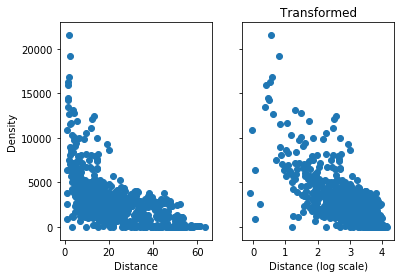

In [2675]:
# Check for outliers
x = distance
y = density

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter((x),(y))
ax1.set_xlabel('Distance')
ax1.set_ylabel('Density')
ax2.scatter(np.log(x),(y))
ax2.set_xlabel('Distance (log scale)')
ax2.set_title('Transformed')

The left scatterplot shows that there is a large variance in density at different distances. Therefore regression modelling will not be a reliable method to predict the population density as a function of distance.

This is further exemplified by transforming the distance data to a log scale. The aim here was was to show that if the scatter plot on the left was an exponential pattern, and log transformation should turn it to a linear pattern. As we can see with the scatter plot on the right, the density variance at different distances is still considerably large.

Therefore, I will not pursue with regression modelling to interpolate the missing data.

# Group database by mean

Group local government area (LGA) and create box whisker plots of density distribution.

In [2763]:
model_data

,LGA,Population,Postcode,Suburb,lat,lon,polygon,geo_dist,geo_area,Density
0,Canterbury-Bankstown Council,32113.0,2200,Bankstown,-33.9172,151.034,"{'type': 'Polygon', 'coordinates': [[[151.0111...",17.19,6.304521,5093.645985
1,Waverley Council,11656.0,2026,Bondi Beach,-33.8907,151.272,"{'type': 'Polygon', 'coordinates': [[[151.2624...",6.29,1.168933,9971.487201
2,City of Sydney,17252.0,2000,Sydney central business district,-33.868,151.21,"{'type': 'Polygon', 'coordinates': [[[151.1970...",0.00,2.857102,6038.285546
3,City of Willoughby,24913.0,2067,Chatswood,-33.7945,151.182,"{'type': 'Polygon', 'coordinates': [[[151.1588...",8.58,4.798930,5191.365872
4,Sutherland Shire,18070.0,2230,Cronulla,-34.0575,151.152,"{'type': 'Polygon', 'coordinates': [[[151.1432...",21.75,5.180236,3488.258086
5,City of Liverpool,27084.0,2170,Liverpool,-33.9198,150.926,"{'type': 'Polygon', 'coordinates': [[[150.8981...",26.88,6.242770,4338.458789
6,Northern Beaches Council,15866.0,2095,Manly,-33.8039,151.291,"{'type': 'Polygon', 'coordinates': [[[151.2745...",10.32,5.400149,2938.067007
7,North Sydney Council,2158.0,2061,Milsons Point,-33.8471,151.212,"{'type': 'Polygon', 'coordinates': [[[151.2092...",2.32,0.187069,11535.847411
8,Mosman Council,28475.0,2088,Mosman,-33.8301,151.245,"{'type': 'Polygon', 'coordinates': [[[151.2283...",5.29,8.442359,3372.872446
9,City of Sydney Inner West Council,15029.0,2042,Newtown,-33.8961,151.18,"{'type': 'Polygon', 'coordinates': [[[151.1710...",4.17,1.542517,9743.168771


In [2764]:
grouped = model_data.groupby(["LGA"]).agg({'Suburb':', '.join,\
                                           'Density':lambda x: x.mean(skipna=True),\
                                           'geo_area': lambda x: x.mean(skipna=True),\
                                           'geo_dist': lambda x: x.mean(skipna=True),\
                                           'Population': lambda x: x.mean(skipna=True)}).reset_index()

In [2767]:
grouped_sort_dist = grouped.sort_values(by=['geo_dist'])

In [2775]:
grouped_sort_dist.head(30)

,LGA,Suburb,Density,geo_area,geo_dist,Population
63,City of Sydney,"Sydney central business district, The Rocks, A...",9934.259471,0.834760,2.352308,6987.807692
22,City of Sydney Municipality of Woollahra,Paddington,8091.544287,1.595616,2.400000,12911.000000
98,Woollahra Council,"Darling Point, Double Bay",6217.635202,0.711958,2.875000,4416.000000
85,North Sydney Council,"Milsons Point, Cammeray, Cremorne, Cremorne Po...",6791.253932,0.783191,3.570000,5053.384615
84,Municipality of Woollahra,"Bellevue Hill, Edgecliff, Point Piper, Woollahra",5799.027919,1.050180,3.690000,5531.250000
21,City of Sydney Inner West Council,"Newtown, Camperdown",8449.477419,1.493820,3.920000,12685.000000
64,"City of Sydney, City of Randwick",Centennial Park,1110.831491,2.138938,3.980000,2376.000000
39,Waverley Council Municipality of Woollahra,Rose Bay,4074.711405,2.467169,5.160000,10053.000000
78,Mosman Council,Mosman,3372.872446,8.442359,5.290000,28475.000000
81,"Municipality of Lane Cove, North Sydney Counci...",St Leonards,7086.803541,0.775385,5.310000,5495.000000


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 <a list of 99 Text xticklabel objects>)

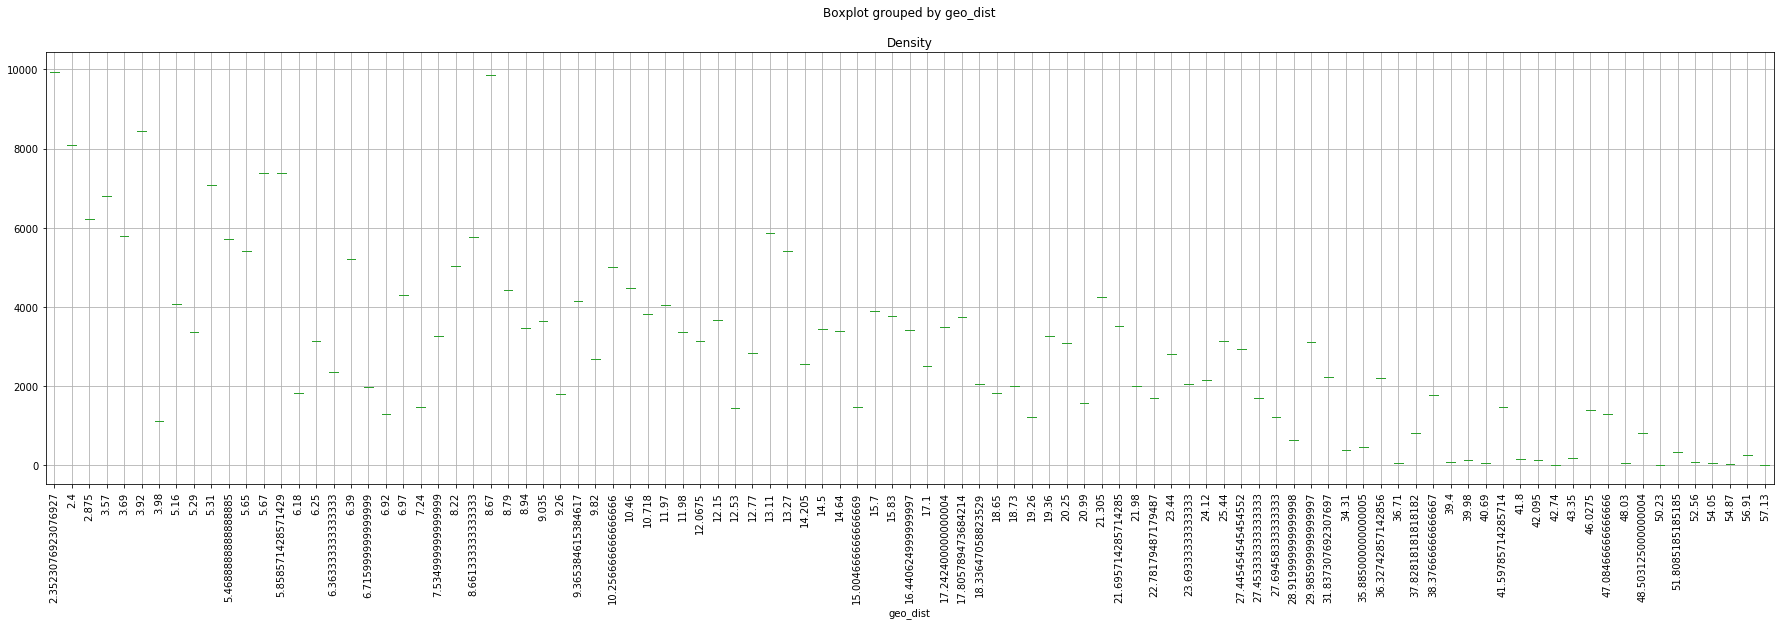

In [2774]:
fig, ax = plt.subplots(figsize=(30,8))
grouped_sort_dist.boxplot(column='Density', by='geo_dist', ax=ax)
plt.xticks(rotation=90)

Text(0, 0.5, 'Population density (people/km^2)')

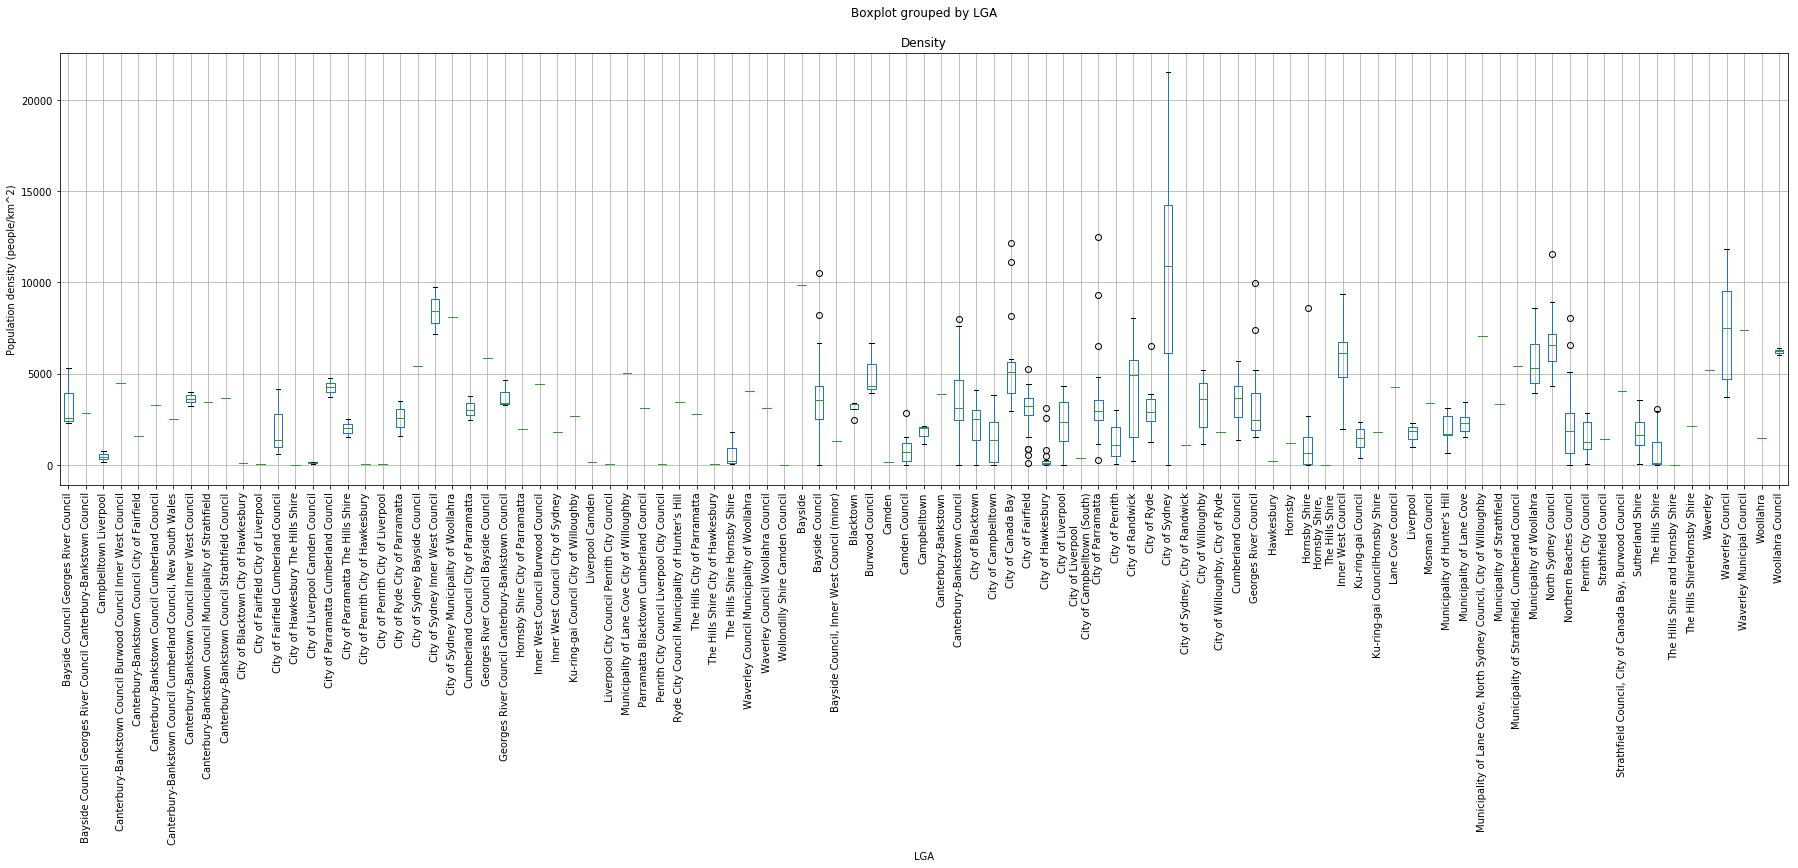

In [2749]:
fig, ax = plt.subplots(figsize=(30,8))
#plt.suptitle('')
model_data.boxplot(column=['Density'], by='LGA', ax=ax)
plt.xticks(rotation=90)
plt.ylabel('Population density (people/km^2)')

Sydney suburb dataframe grouped according to the postcodes.

# Scrape information about each Brisbane suburb from Wikipedia

In [12]:
with open("view-source_https___en.wikipedia.org_wiki_List_of_Brisbane_suburbs.html") as html_file:
    soup = BeautifulSoup(html_file, "lxml")

bri_suburbs_section = soup.find('div',attrs={'id':'mw-content-text', 'class':'mw-content-ltr'})
bri_suburbs_section = bri_suburbs_section.find_all('a', href=True)

In [13]:
wiki_state_name = ', Queensland'
wiki_link_extension = ',_Queensland'
state = 'Brisbane'
bne_wiki_urls = get_wiki_urls(bri_suburbs_section, wiki_link_extension, wiki_state_name, state)

In [14]:
bne_suburb_infobox = get_suburb_wiki_infobox(bne_wiki_urls)

In [15]:
brisbane_suburbs = get_suburb_info(bne_suburb_infobox)

In [16]:
# Convert Brisbane suburbs nested dictionary to a dataframe
brisbane_suburbs_df = pd.DataFrame(brisbane_suburbs).T
brisbane_suburbs_df['Suburb'] = brisbane_suburbs_df.index
brisbane_suburbs_df.index = range(brisbane_suburbs_df.shape[0])

brisbane_suburbs_df.head(10)

,Area,Density,LGA,Location,Postcode,Suburb
0,2.07,4570,City of Brisbane(Central Ward),NaN,4000,Brisbane central business district
1,1.7,1900,City of Brisbane(Central Ward),NaN,4006,Bowen Hills
2,2,3000,City of Brisbane (The Gabba Ward),2.5,4169,East Brisbane
3,1.4,4980,City of Brisbane(Central Ward),1,4006,Fortitude Valley
4,1.7,1300,City of Brisbane(Central Ward),3,4006,Herston
5,1.2,5160,City of Brisbane (The Gabba Ward),2,4101,Highgate Hill
6,1.3,6200,City of Brisbane (The Gabba Ward),NaN,4169,Kangaroo Point
7,NaN,NaN,City of Brisbane(Paddington Ward),NaN,4059,Kelvin Grove
8,2,6300,City of Brisbane(Central Ward),2,4005,New Farm
9,1.3,1690,City of Brisbane(Central Ward),3,4006,Newstead


Find and replace cells where the Area, Density, or Location is 0 to a nan. These values can be extrapolated later if necessary from their location and area data by regression modelling.

In [17]:
#brisbane_suburbs_df.loc[brisbane_suburbs_df['Area'] == 0.0]
#brisbane_suburbs_df.loc[brisbane_suburbs_df['Density'] == 0.0]
#brisbane_suburbs_df.loc[brisbane_suburbs_df['Location'] == 0.0]
brisbane_suburbs_df['Density'] = brisbane_suburbs_df['Density'].replace(0, np.nan)

Check the density values for Mount Coot-tha and Spring Mountain have changed. Should be NaN.

In [18]:
brisbane_suburbs_df.loc[brisbane_suburbs_df['Suburb'].isin(['Mount Coot-tha','Spring Mountain'])]
#brisbane_suburbs_df[brisbane_suburbs_df['Suburb'].str.contains('Mount Coot-tha|Spring Mountain')==True]

,Area,Density,LGA,Location,Postcode,Suburb
169,16.6,NaN,City of Brisbane(Toowong Ward),NaN,4066,Mount Coot-tha
251,19.1,NaN,City of Ipswich,None,4124,Spring Mountain


Brisbane suburb dataframe grouped according to their postcodes.

In [19]:
bne_suburbs_grouped = brisbane_suburbs_df.groupby(["Postcode"]).agg({'Suburb':', '.join,\
                                                                         'Area': lambda x: x.mean(skipna=True),\
                                                                         'Density': lambda x: x.mean(skipna=True),\
                                                                         'Location': lambda x: x.mean(skipna=True)}).reset_index()
bne_suburbs_grouped = bne_suburbs_grouped.assign(State='QLD')
bne_suburbs_grouped.head(10)

,Postcode,Suburb,Area,Density,Location,State
0,4000,"Brisbane central business district, Petrie Ter...",1.635,4775.0,2.000000,QLD
1,4005,"New Farm, Teneriffe",1.500,5820.0,2.250000,QLD
2,4006,"Bowen Hills, Fortitude Valley, Herston, Newstead",1.525,2467.5,2.333333,QLD
3,4007,"Ascot, Hamilton",2.200,3125.0,7.500000,QLD
4,4008,Pinkenba,NaN,NaN,9.000000,QLD
5,4009,Eagle Farm,NaN,NaN,9.000000,QLD
6,4010,Albion,1.400,1640.0,6.000000,QLD
7,4011,"Clayfield, Hendra",2.800,2675.0,8.000000,QLD
8,4012,"Nundah, Wavell Heights",4.100,2737.5,11.900000,QLD
9,4013,Northgate,3.100,1388.0,NaN,QLD


# Get geographical coordinates for each suburb

In [20]:
def get_latlong(df_pc, state):
    geolocator = Nominatim(user_agent="specify_your_app_name_here", timeout=3)
    
    lat = []
    long = []

    for index,row in df_pc.iterrows():
        postcode = row.Postcode
        suburb = row.Suburb
        location = geolocator.geocode("{} {} {} Australia".format(suburb, postcode, state))
        lat.append(location.latitude)
        long.append(location.longitude)

    latlong = dict({'lat':lat, 'long':long})
    latlong_df = pd.DataFrame(latlong)
    
    return latlong_df

In [21]:
# Geospatial coordinates for Sydney suburbs
latlong_syd = get_latlong(syd_suburbs_grouped, 'New South Wales')

In [22]:
# Geospatial coordinates for Brisbane suburbs
latlong_bne = get_latlong(bne_suburbs_grouped, 'Queensland')

### Merge the latlong dataframe with the suburbs_pc dataframe

In [23]:
syd_suburbs_coord = pd.concat([syd_suburbs_grouped, latlong_syd], axis=1)
bne_suburbs_coord = pd.concat([bne_suburbs_grouped, latlong_bne], axis=1)

### Calculate geographical distances

In [280]:
# Create dataframe list of suburbs and their latitude and longitude alone
suburb_distances = top_venues[['Suburb', 'Suburb Latitude', 'Suburb Longitude']]

# Group by suburb column
suburb_distances = suburb_distances.groupby(['Suburb']).mean()

# Create integer index column
suburb_distances['Suburb'] = suburb_distances.index
suburb_distances.index = range(suburb_distances.shape[0])

# Function that calculates the distance from different suburbs to the cbd using latitude and longitude coordinates
def calc_dist_from_cbd():
    return


cbd_latitude = suburb_distances[suburb_distances['Suburb'].str.contains("central business district|cbd")==True]
cbd_longitude = []


suburb_latitude = suburb_distances['Suburb Latitude']
suburb_distances['Suburb Latitude'] * 2

def calc_dist_from_cbd():
    return

# Plotting Sydney and Brisbane suburbs on maps

### Plotting Sydney suburb map

In [24]:
address = "Sydney, New South Wales"
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sydney, NSW are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sydney, NSW are -33.8548157, 151.2164539.


In [25]:
# create map of Toronto using latitude and longitude values
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=9.5)
# add markers to map
for lat, lng, postcode, suburb in zip(syd_suburbs_coord['lat'],\
                                      syd_suburbs_coord['long'],\
                                      syd_suburbs_coord['Postcode'],\
                                      syd_suburbs_coord['Suburb']):
    #print(lat, lng)
    label = '{}: {}'.format(postcode, suburb)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)  
    
map_sydney

### Plotting Brisbane suburb map

In [26]:
address = "Brisbane, Queensland"
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brisbane, Queensland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brisbane, Queensland are -27.4689682, 153.0234991.


In [27]:
# create map of Toronto using latitude and longitude values
map_brisbane = folium.Map(location=[latitude, longitude], zoom_start=9.5)
# add markers to map
for lat, lng, postcode, suburb in zip(bne_suburbs_coord['lat'],\
                                      bne_suburbs_coord['long'],\
                                      bne_suburbs_coord['Postcode'],\
                                      bne_suburbs_coord['Suburb']):
    #print(lat, lng)
    label = '{}: {}'.format(postcode, suburb)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brisbane)  
    
map_brisbane

# Search for local venues in Sydney and Brisbane suburbs with Foursquare API

### Define Foursquare credentials and version

In [28]:
CLIENT_ID = 'JVA5H5NJXBQTUPSMHXXD0V0NKNP0OVJO0GKU1WJGLER5Q0DU' # Foursquare ID
CLIENT_SECRET = 'DMZV42OBBRZNSPQSGEUD3PE3N5EHUKRZYRTMSCLSORKPAO2W' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JVA5H5NJXBQTUPSMHXXD0V0NKNP0OVJO0GKU1WJGLER5Q0DU
CLIENT_SECRET:DMZV42OBBRZNSPQSGEUD3PE3N5EHUKRZYRTMSCLSORKPAO2W


# Explore suburbs of Sydney

In [29]:
suburbs_coord = pd.concat([syd_suburbs_coord, bne_suburbs_coord], axis=0)
suburbs_coord.shape

(358, 8)

Function that finds top 100 venues within 500m radius of the neighbourhood

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Here, I use the function to create a new dataframe that includes the venues.

In [31]:
top_venues = getNearbyVenues(names=suburbs_coord['Suburb'],
                             latitudes=suburbs_coord['lat'],
                             longitudes=suburbs_coord['long'])

Check size of dataframe

In [32]:
print(top_venues.shape)
top_venues.head(5)

(4025, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,The Baxter Inn,-33.869707,151.205467,Whisky Bar
1,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,State Theatre,-33.871291,151.207049,Theater
2,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,Queen Victoria Building (QVB),-33.871521,151.206741,Shopping Mall
3,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,Uniqlo,-33.869744,151.208319,Clothing Store
4,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,Haigh's Chocolates,-33.869207,151.207129,Candy Store


The number of unique categories that can be curated from all of the returned venues

In [33]:
print('There are {} uniques categories.'.format(len(top_venues['Venue Category'].unique())))

There are 288 uniques categories.


### Calculate distance from cbd using latitude and longitude coordinates

# Analysing each Suburb in Sydney and Brisbane

Here our aim is to show which suburbs in Brisbane are the most similar to a selected suburb in Sydney. To do this we will cluster Brisbane suburbs according to their top venues. Each cluster will share similarities in their top suburbs. Therefore it is ideal to have every suburb associated with a cluster even it is remotely similar. To do this we shall perform a hard-clustering technique such as 'K-means clustering'. Once we have grouped Brisbane suburbs into clusters, we will determine which of these groups are most similar to each suburb in Sydney. This will be done performing a classification k-nearest neighbour on the selected Sydney suburb with the Brisbane suburb clusters. Therefore, the clustered points that are nearest to the Sydney suburb will be the identified as the Brisbane suburbs that are most similar to the Sydney suburb.

In [34]:
# one hot encoding
top_venues_onehot = pd.get_dummies(top_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
top_venues_onehot['Suburb'] = top_venues['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [top_venues_onehot.columns[-1]] + list(top_venues_onehot.columns[:-1])
top_venues_onehot = top_venues_onehot[fixed_columns]

top_venues_onehot.head()

,Suburb,Advertising Agency,Airport,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine the shape of the dataframe size

In [35]:
top_venues_onehot.shape

(4025, 289)

Group suburbs and calculate the mean of the frequency of occurance for each category

In [36]:
top_venues_grouped = top_venues_onehot.groupby('Suburb').mean().reset_index()
top_venues_grouped

,Suburb,Advertising Agency,Airport,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,"Abbotsbury, Bossley Park, Edensor Park, Greenf...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
1,"Abbotsford, Canada Bay, Chiswick, Five Dock, R...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
2,"Acacia Gardens, Quakers Hill",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
3,"Acacia Ridge, Heathwood, Larapinta, Pallara, W...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
4,Albion,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
5,"Alderley, Gaythorne, Grange, Newmarket, Wilsto...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
6,"Alexandria, Beaconsfield, Eveleigh",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
7,"Alfords Point, Bangor, Barden Ridge, Illawong,...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.250000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
8,"Algester, Parkinson",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
9,"Allambie Heights, Beacon Hill, Brookvale, Nort...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0


In [37]:
top_venues_grouped.shape

(313, 289)

Some suburbs were not returned because those suburbs didn't have 10 venues within 500m listed on Foursquare.


Function that sorts most frequent venues in descending order

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating a new dataframe and display the top 10 venues for each neighbourhood

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_venues_sorted = pd.DataFrame(columns=columns)
top_venues_sorted['Suburb'] = top_venues_grouped['Suburb']

for ind in np.arange(top_venues_grouped.shape[0]):
    top_venues_sorted.iloc[ind, 1:] = return_most_common_venues(top_venues_grouped.iloc[ind, :], num_top_venues)

top_venues_sorted.head(5)

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbotsbury, Bossley Park, Edensor Park, Greenf...",Chinese Restaurant,Grocery Store,Café,Pub,Dessert Shop,Filipino Restaurant,Fried Chicken Joint,French Restaurant,Fountain,Forest
1,"Abbotsford, Canada Bay, Chiswick, Five Dock, R...",Gym,Grocery Store,Bus Station,Park,Mediterranean Restaurant,Café,Convenience Store,Martial Arts Dojo,Flea Market,Filipino Restaurant
2,"Acacia Gardens, Quakers Hill",Fast Food Restaurant,Snack Place,Baseball Field,Gas Station,Pizza Place,Convenience Store,Sandwich Place,Filipino Restaurant,Fish & Chips Shop,Fish Market
3,"Acacia Ridge, Heathwood, Larapinta, Pallara, W...",Furniture / Home Store,Yoga Studio,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
4,Albion,Café,Indian Restaurant,Turkish Restaurant,Fast Food Restaurant,Comedy Club,Sandwich Place,Seafood Restaurant,Thai Restaurant,Bakery,Train Station


Function to find Suburb and have a look at their top venues

In [40]:
def suburb_top_venues(venues_sorted, suburb_of_interset):
    return venues_sorted[venues_sorted['Suburb'].str.contains(suburb_of_interset)]

suburb_top_venues(top_venues_sorted, 'Randwick')

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
117,"Clovelly, Randwick",Café,Thai Restaurant,Burger Joint,Dessert Shop,Hotel,Pub,Supermarket,Gym,Fast Food Restaurant,Tapas Restaurant


# Cluster Brisbane Suburbs

In [41]:
# Split data from NSW to QLD
search_values = syd_suburbs_coord['Suburb'].values
syd_section = top_venues_grouped[top_venues_grouped.Suburb.str.contains('|'.join(search_values ))]
syd_section.index = pd.RangeIndex(len(syd_section.index))

In [42]:
syd_section.shape

(206, 289)

In [43]:
search_values = bne_suburbs_coord['Suburb'].values
bne_section = top_venues_grouped[top_venues_grouped.Suburb.str.contains('|'.join(search_values ))]
bne_section.index = pd.RangeIndex(len(bne_section.index))

/Users/Jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [44]:
bne_section

,Suburb,Advertising Agency,Airport,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,"Acacia Ridge, Heathwood, Larapinta, Pallara, W...",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
1,Albion,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
2,"Alderley, Gaythorne, Grange, Newmarket, Wilsto...",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
3,"Algester, Parkinson",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
4,"Amity Point, Dunwich, Point Lookout",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
5,"Annerley, Fairfield",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
6,"Anstead, Bellbowrie, Moggill",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
7,"Archerfield, Coopers Plains",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
8,"Ascot, Hamilton",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
9,Ashgrove,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0


Check shape of dataframe

In [45]:
print(syd_section.shape)
print(bne_section.shape)
print(top_venues_grouped.shape)

(206, 289)
(108, 289)
(313, 289)


Perform Cluster analysis with Brisbane suburbs

In [46]:
# Drop suburb column for cluster analysis
bne_venues_matrix_values = bne_section.drop('Suburb', 1)

Function that calculates euclidean distances for all points to their assigned cluster centroid.

In [47]:
def k_mean_distance(data, cantroid_matrix, i_centroid, cluster_labels):
    distances = [np.linalg.norm(x-cantroid_matrix) for x in data[cluster_labels == i_centroid]]
    return np.mean(distances)

In [48]:
k_optimisation = {}
nclusters = 20
clustering_matrix = bne_venues_matrix_values.values

for k in range(nclusters):
    k_means = KMeans(init = "k-means++", n_clusters = k+1, n_init = 100, random_state=10)
    k_means.fit(bne_venues_matrix_values)

    k_means_labels = k_means.labels_
    k_means_cluster_centers = k_means.cluster_centers_

    c_mean_distances = []
    for i, cent_features in enumerate(k_means_cluster_centers):
                mean_distance = k_mean_distance(clustering_matrix, cent_features, i, k_means_labels)
                c_mean_distances.append(mean_distance)

    k_optimisation[k+1] = np.mean(c_mean_distances)

Plot mean distances against number of k's

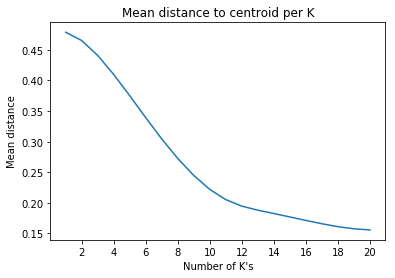

In [49]:
# sorted by key, return a list of tuples
lists = sorted(k_optimisation.items())
# unpack a list of pairs into two tuples
x, y = zip(*lists)
# Smooth data
ysmoothed = gaussian_filter1d(y, sigma=2)

x_ticks = x[1::2]
plt.plot(x, ysmoothed)
plt.xticks(x[1::2])
plt.xlabel('''Number of K's''')
plt.ylabel('Mean distance')
plt.title('Mean distance to centroid per K')
plt.show()

The inflexion point on the graph is approximately at 11. Therefore we will use 11 as our K value.

In [50]:
kclusters = 11
k_means = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 100, random_state=10)
k_means.fit(bne_venues_matrix_values)

k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

In [51]:
k_means_labels

array([ 0,  1,  1,  1,  2,  1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  9,  1,  1,  9,  1,  1,  1,  5,  9,  1,  1,  1,  1,  1,  8,  1,
        9, 10,  1,  1,  1,  1,  2,  3,  9,  1, 10,  1,  1,  9,  1,  1,  1,
        1,  1,  1,  1,  5,  1,  2,  1,  6,  9,  1,  2,  1,  1,  9,  2,  1,
        1,  2,  1,  1,  1,  8,  9,  1,  9,  1,  1,  9,  1,  1,  1,  1,  1,
        8,  1,  2,  8,  1,  1,  1,  4,  7,  1,  9,  1,  1,  1,  9,  1,  1,
        1,  9,  1,  1,  1,  1], dtype=int32)

Add cluster labels

In [52]:
# add clustering labels
search_values = bne_section['Suburb'].values
bne_venues_sorted = top_venues_sorted[top_venues_sorted.Suburb.str.contains('|'.join(search_values ))]

bne_suburbs_coord_update = bne_suburbs_coord[bne_suburbs_coord.Suburb.str.contains('|'.join(search_values ))]


bne_venues_sorted.insert(0, 'Cluster Labels', k_means_labels)
bne_merged = bne_suburbs_coord_update

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bne_merged = bne_merged.join(bne_venues_sorted.set_index('Suburb'), on='Suburb')
bne_merged.index = pd.RangeIndex(len(bne_merged.index))
bne_merged.head(10) # check the last columns!

,Postcode,Suburb,Area,Density,Location,State,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4000,"Brisbane central business district, Petrie Ter...",1.635,4775.0,2.000000,QLD,-27.467224,153.027740,1,Café,Burger Joint,Bar,Coffee Shop,Hotel,Japanese Restaurant,Sushi Restaurant,Restaurant,Italian Restaurant,Plaza
1,4005,"New Farm, Teneriffe",1.500,5820.0,2.250000,QLD,-27.464018,153.045491,1,Café,Italian Restaurant,Indian Restaurant,BBQ Joint,Deli / Bodega,Coffee Shop,Cocktail Bar,Shopping Mall,Burger Joint,Supermarket
2,4006,"Bowen Hills, Fortitude Valley, Herston, Newstead",1.525,2467.5,2.333333,QLD,-27.459367,153.038752,1,Coffee Shop,Japanese Restaurant,Bar,Pub,Cocktail Bar,Café,Beer Bar,Burger Joint,Asian Restaurant,Pizza Place
3,4007,"Ascot, Hamilton",2.200,3125.0,7.500000,QLD,-27.433788,153.063037,1,Café,Burger Joint,Japanese Restaurant,Sandwich Place,Flea Market,Bakery,Noodle House,Grocery Store,Thai Restaurant,Italian Restaurant
4,4008,Pinkenba,NaN,NaN,9.000000,QLD,-27.374745,153.122608,4,Airport Terminal,Zoo Exhibit,Food Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Football Stadium
5,4009,Eagle Farm,NaN,NaN,9.000000,QLD,-27.432873,153.090375,1,Go Kart Track,Diner,Zoo Exhibit,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
6,4010,Albion,1.400,1640.0,6.000000,QLD,-27.430104,153.042181,1,Café,Indian Restaurant,Turkish Restaurant,Fast Food Restaurant,Comedy Club,Sandwich Place,Seafood Restaurant,Thai Restaurant,Bakery,Train Station
7,4011,"Clayfield, Hendra",2.800,2675.0,8.000000,QLD,-27.427707,153.046410,1,Sushi Restaurant,Indian Restaurant,Convenience Store,Bus Station,Breakfast Spot,Café,Seafood Restaurant,Thai Restaurant,Bakery,Fast Food Restaurant
8,4012,"Nundah, Wavell Heights",4.100,2737.5,11.900000,QLD,-27.393142,153.048584,1,Café,Liquor Store,Bakery,Pizza Place,Home Service,Food Court,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
9,4013,Northgate,3.100,1388.0,NaN,QLD,-27.391140,153.069953,8,Brewery,Gym,Garden,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service


Plot clusters onto map

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, suburb, cluster in zip(bne_merged['lat'], bne_merged['long'], bne_merged['Suburb'], bne_merged['Cluster Labels']):
    label = folium.Popup(str(suburb) + ': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Here the suburbs are clustered according to their top venues. Therefore suburbs that are north of Brisbane such as Burpengary (cluster 1) would be similar to suburbs close to the city such as East Brisbane and Kangaroo Point.
Although the suburbs are similar in regards to the local venues, they are vastly different in population density, area, and distance from the cbd. For example the Burpengary the population density is These attributes should also be taken into consideration when buyers from Sydney are looking for a home in Brisbane.
These attributes were conveniently scraped earlier from Wikipedia.

### Data wrangling for regression modelling

In [54]:
bne_area = bne_merged['Area'].values
bne_density = bne_merged['Density'].values
bne_distance = bne_merged['Location'].values

In [55]:
print('''Area has {} nan's'''.format(np.count_nonzero(np.isnan(bne_area))))
print('')
print('''Density has {} nan's'''.format(np.count_nonzero(np.isnan(bne_density))))
print('')
print('''Distance has {} nan's'''.format(np.count_nonzero(np.isnan(bne_distance))))

Area has 28 nan's

Density has 29 nan's

Distance has 14 nan's


Inspect the rows with the missing values in the brisbane suburb dataframe.

In [56]:
# Show rows that have a NaN value
bne_merged[bne_merged.isnull().any(axis=1)]

,Postcode,Suburb,Area,Density,Location,State,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,4008,Pinkenba,NaN,NaN,9.000000,QLD,-27.374745,153.122608,4,Airport Terminal,Zoo Exhibit,Food Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Football Stadium
5,4009,Eagle Farm,NaN,NaN,9.000000,QLD,-27.432873,153.090375,1,Go Kart Track,Diner,Zoo Exhibit,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
9,4013,Northgate,3.10,1388.00,NaN,QLD,-27.391140,153.069953,8,Brewery,Gym,Garden,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
11,4018,"Fitzgibbon, Taigum",NaN,NaN,14.500000,QLD,-27.342192,153.038350,1,Supermarket,Shopping Mall,Playground,Zoo Exhibit,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
12,4019,"Clontarf, Margate, Woody Point",6.30,1314.00,NaN,QLD,-27.256934,153.096005,2,Park,Seafood Restaurant,Gas Station,Bowling Green,Bus Station,Food Court,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
13,4020,"Newport, Redcliffe, Scarborough",NaN,NaN,28.000000,QLD,-27.221432,153.109551,2,Park,Business Service,Food Court,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Zoo Exhibit
14,4021,Kippa-Ring,NaN,NaN,NaN,QLD,-27.222065,153.086233,1,Café,Movie Theater,Donut Shop,Fried Chicken Joint,Supermarket,Mobile Phone Shop,Food Court,Auto Dealership,Fast Food Restaurant,Department Store
15,4022,Rothwell,10.10,709.00,NaN,QLD,-27.214952,153.057710,9,Carpet Store,Performing Arts Venue,Bus Station,Zoo Exhibit,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food Court
28,4061,The Gap,12.20,1368.00,NaN,QLD,-27.444412,152.943180,1,Museum,Grocery Store,Thai Restaurant,Trail,Bus Station,Convenience Store,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market
30,4065,Bardon,4.90,1939.00,NaN,QLD,-27.459950,152.981611,1,Gym,Supermarket,Playground,Zoo Exhibit,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop


Rows where all three attributes are NaN's should be removed from the dataframe since none of the values can be extrapolated from each other with regression modelling.

In [57]:
# Find rows where the area, density, and distance are all NaN's.
attributes_all_nan = bne_merged[bne_merged['Area'].isnull() & (bne_merged['Density'].isnull()) & (bne_merged['Location'].isnull())]

In [58]:
# Remove those rows where all three attributes are NaN's from the main dataframe.
bne_reg_data = pd.concat([bne_merged, attributes_all_nan]).drop_duplicates(keep=False)

In [83]:
# Split dataframe from rows that contain NaN's to those that don't contain Nan's
bne_reg_data_model = bne_reg_data[bne_reg_data['Area'].notnull() & (bne_reg_data['Density'].notnull()) & (bne_reg_data['Location'].notnull())]
bne_reg_data_predict = bne_reg_data[(bne_reg_data['Area'].isnull()) | (bne_reg_data['Density'].isnull()) | (bne_reg_data['Location'].isnull())]

In [84]:
bne_reg_data_predict

,Postcode,Suburb,Area,Density,Location,State,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,4008,Pinkenba,NaN,NaN,9.000000,QLD,-27.374745,153.122608,4,Airport Terminal,Zoo Exhibit,Food Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Football Stadium
5,4009,Eagle Farm,NaN,NaN,9.000000,QLD,-27.432873,153.090375,1,Go Kart Track,Diner,Zoo Exhibit,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
9,4013,Northgate,3.10,1388.00,NaN,QLD,-27.391140,153.069953,8,Brewery,Gym,Garden,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
11,4018,"Fitzgibbon, Taigum",NaN,NaN,14.500000,QLD,-27.342192,153.038350,1,Supermarket,Shopping Mall,Playground,Zoo Exhibit,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
12,4019,"Clontarf, Margate, Woody Point",6.30,1314.00,NaN,QLD,-27.256934,153.096005,2,Park,Seafood Restaurant,Gas Station,Bowling Green,Bus Station,Food Court,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
13,4020,"Newport, Redcliffe, Scarborough",NaN,NaN,28.000000,QLD,-27.221432,153.109551,2,Park,Business Service,Food Court,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Zoo Exhibit
15,4022,Rothwell,10.10,709.00,NaN,QLD,-27.214952,153.057710,9,Carpet Store,Performing Arts Venue,Bus Station,Zoo Exhibit,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food Court
28,4061,The Gap,12.20,1368.00,NaN,QLD,-27.444412,152.943180,1,Museum,Grocery Store,Thai Restaurant,Trail,Bus Station,Convenience Store,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market
30,4065,Bardon,4.90,1939.00,NaN,QLD,-27.459950,152.981611,1,Gym,Supermarket,Playground,Zoo Exhibit,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
31,4066,"Auchenflower, Mount Coot-tha",9.05,3910.00,NaN,QLD,-27.485684,152.992306,1,Chinese Restaurant,Coffee Shop,Asian Restaurant,Indian Restaurant,Convenience Store,Shopping Mall,Sandwich Place,Cocktail Bar,Resort,Ramen Restaurant


In [89]:
print('Full dataframe: {}'.format(bne_merged.shape))
print('All NaN rows: {}'.format(attributes_all_nan.shape))
print('Removed rows where all three attributes are NaN: {}'.format(bne_reg_data.shape))
print('Model dataframe: {}'.format(bne_reg_data_model.shape))
print('Predict dataframe: {}'.format(bne_reg_data_predict.shape))

Full dataframe: (108, 19)
All NaN rows: (4, 19)
Removed rows where all three attributes are NaN: (104, 19)
Model dataframe: (69, 19)
Predict dataframe: (35, 19)


### Check histograms of area, density, and distance to see if data needs to be transformed to obtain a normal distribution

Missing values for area, Population density, and distance from cbd will be interpolated from regression modelling. Here I hypothesize that suburbs further away from the cbd are both larger and have a smaller population density.

* Firstly, I need check their distributions by plotting the data onto histograms. Then I'll see if data needs to be transformed to obtain a normal distribution.
* Secondly, I will generate scatterplots to see if there's a correlation between area, population density, and distance.
* Assuming that there will be a correlation between area, population density, and distance, I will interpolate the missing values from the regression models.

Plot data as a histogram and find appropriate transformation method

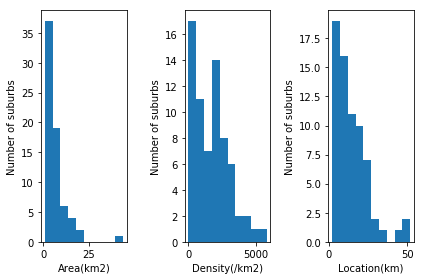

In [92]:
# Remove all nan's for histogram
bne_area_hist = bne_reg_data_model['Area']
bne_density_hist = bne_reg_data_model['Density']
bne_location_hist = bne_reg_data_model['Location']

plt.subplot(1, 3, 1)
plt.hist(bne_area)
plt.xlabel('Area(km2)')
plt.ylabel('Number of suburbs')

plt.subplot(1, 3, 2)
plt.hist(bne_density)
plt.xlabel('Density(/km2)')
plt.ylabel('Number of suburbs')

plt.subplot(1, 3, 3)
plt.hist(bne_distance)
plt.xlabel('Location(km)')
plt.ylabel('Number of suburbs')

plt.tight_layout()
plt.show()

Here will transform our area, density, and location data to create a model that makes sense of your data. This will be displayed as scatterplots.

In [223]:
bne_area_transformed = np.log(bne_reg_data_model['Area'])
bne_density_transformed = np.sqrt(bne_reg_data_model['Density'])
bne_location_transformed = np.log(bne_reg_data_model['Location'])

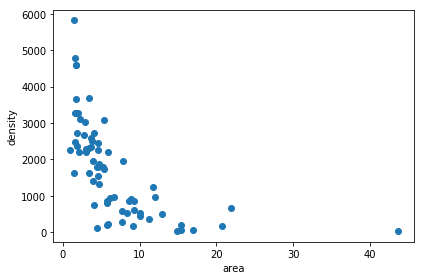

In [226]:
bne_area = (bne_reg_data_model['Area'])
bne_density = (bne_reg_data_model['Density'])
bne_location = (bne_reg_data_model['Location'])

#plt.subplot(131)
plt.scatter((bne_area), (bne_density))
plt.xlabel('area')
plt.ylabel('density')

plt.tight_layout()
#plt.show()

Here it looks like there is an exponential relationship between the area of a suburb and the population density.

Text(0, 0.5, 'location')

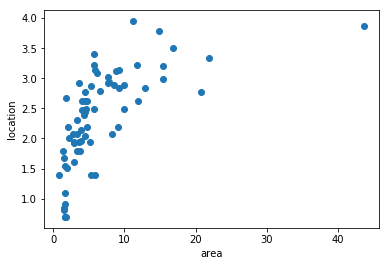

In [238]:
#plt.subplot(132)
plt.scatter((bne_area), np.log(bne_location))
plt.xlabel('area')
plt.ylabel('location')

There is a weaker/uncertain relationship between area and location.

Text(0, 0.5, 'density')

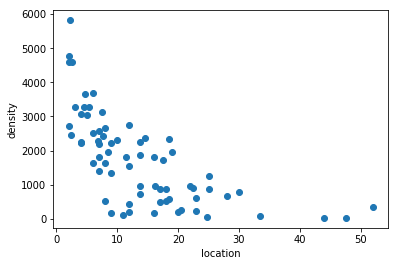

In [211]:
#plt.subplot(133)
plt.scatter((bne_location), (bne_density))
plt.xlabel('location')
plt.ylabel('density')

Exponential relationship

Therefore we will fit these scatter plots to obtain a regression model.
* If we need to predict location we will use density.
* If we need to predict area we will use density.
* If we need to predict density we will use density or area (compare the results just for the sake of interest. If results are similar we can get the mean from both predictions).
* If there's a row where only area data exist, then we can use it to predict the density, and then use the density to predict the location.

### Create Polynomial regression models and generate scatter plots of the suburb attributes against each other and find their r^2 values.

Here I plot the suburb attributes (area, distance, and density) against each other and find the combinations that are the most suitable to interpolate the missing values. The most suitable combinations will be determined by their r^2 values.

Find the indexes where the values are NaN and remove from all three attributes.

In [166]:
reg_data = {'area':bne_area_transformed, 'density':bne_density_transformed, 'location':bne_location_transformed}
reg_df = pd.DataFrame.from_dict(reg_data)
reg_df.head(5)
reg_df.shape

(69, 3)

In [ ]:

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [163]:
# Get all column combination pairs from dataframe
column_pairs = list(itertools.combinations(list(reg_df.columns), 2))

reg_model_eq = {}

for pair in column_pairs:
    column_one = pair[0]
    column_two = pair[1]
    
    x = reg_df[[column_one]]
    y = reg_df[[column_two]]
    
    lm = LinearRegression()
    lm.fit(x, y)
    
    reg_model_eq['{}_{}'.format(column_one, column_two)] = {}
    reg_model_eq['{}_{}'.format(column_one, column_two)]['intercept'] = list(lm.intercept_)[0]
    reg_model_eq['{}_{}'.format(column_one, column_two)]['coefficient'] = list(lm.coef_[0])[0]
    reg_model_eq['{}_{}'.format(column_one, column_two)]['rsquare'] = lm.score(X, Y)

In [164]:
reg_model_eq

{'area_density': {'intercept': 66.24286688872564,
  'coefficient': -17.771942778301693,
  'rsquare': 0.6660234886096603},
 'area_location': {'intercept': 1.0713525436625366,
  'coefficient': 0.8062966747078567,
  'rsquare': -4.485663205034184},
 'density_location': {'intercept': 3.739569151544351,
  'coefficient': -0.036524156220160066,
  'rsquare': -4.097215702978304}}

(0, 4.878982856528472)

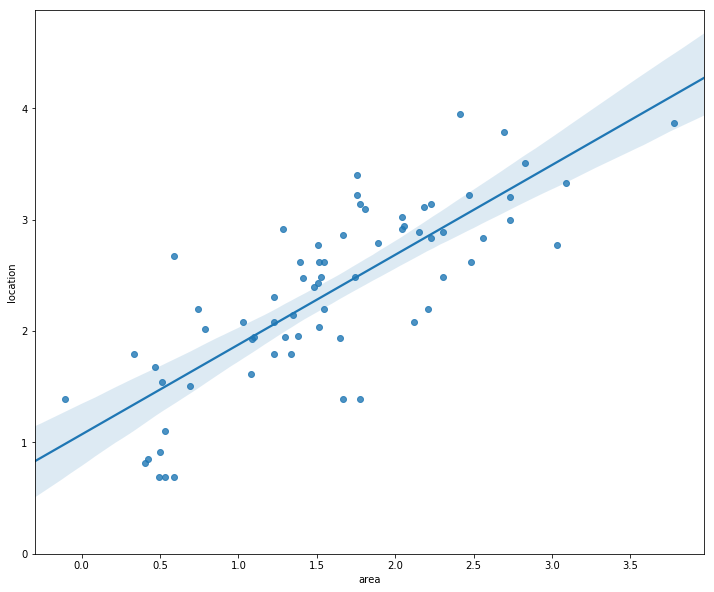

In [165]:

width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(data=reg_df, x='area', y='location')
#sns.jointplot(x, y, kind="reg", stat_func=r2)
plt.ylim(0,)

In [125]:
print('The R-square is: ', lm.score(X, Y))

The R-square is:  0.6660234886096603


In [ ]:
# Add transformed columns onto dataframe

# Convert to dummy variables

# Perform cluster analysis again

# KNN classification with Sydney suburbs and Brisbane clustered data

In [ ]:
bne_merged.shape